In [1]:
import numpy as np

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
import time
from IPython import display
import ipywidgets as widgets
from ipywidgets import interact
#%%  structural FE
class StructuralFE:

    def __init__(self, nelx,nely):
        self.nely, self.nelx = nely,nelx
        self.nele = nelx*nely
        self.penal = 2.0


    def getDMatrix(self):
        E=1
        nu=0.3
        k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
        KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
        [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
        [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
        [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
        [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
        [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
        [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
        [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
        return (KE);
    #-----------------------#
    def initializeSolver(self, force_voxel,Emin = 1e-3, Emax = 1.0):
        self.Emin = Emin;
        self.Emax = Emax;
        self.ndof = 2*(self.nelx+1)*(self.nely+1)
        self.KE=self.getDMatrix();
        dofs=np.arange(self.ndof);
        self.fixed = dofs[0:2*(self.nely+1):1];
        self.free = np.setdiff1d(np.arange(self.ndof),self.fixed);

        idx,idy = np.where(force_voxel)[0], np.where(force_voxel)[1]

        #fid = (idx+1) * 2 * (nely+1) + idy *2 #force node id for x direction 
        fid = (idx+1) * 2 * (self.nely+1) + 1 + idy *2 #force node id for y direction 
        force = np.zeros((self.ndof,1))
        force[fid] = -1.0
        self.f = force;

        self.edofMat=np.zeros((self.nelx*self.nely,8),dtype=int)
        for elx in range(self.nelx):
            for ely in range(self.nely):
                el = ely+elx*self.nely
                n1=(self.nely+1)*elx+ely
                n2=(self.nely+1)*(elx+1)+ely
                self.edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

        self.iK = np.kron(self.edofMat,np.ones((8,1))).flatten()
        self.jK = np.kron(self.edofMat,np.ones((1,8))).flatten()

    #-----------------------#
    @tf.custom_gradient
    def compliance(self, density):
        
        density = np.reshape(tf.transpose(density),[1,-1])
        self.u=np.zeros((self.ndof,1))
        # solve
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(0.01 + density)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()
        K = K[self.free,:][:,self.free]
        self.u[self.free,0]=spsolve(K,self.f[self.free,0])
        Ei = self.Emin + density**self.penal*(self.Emax-self.Emin)
        ce = (np.dot(self.u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)
        c = np.sum(density**self.penal*ce)
        c = tf.convert_to_tensor(c, dtype=tf.float32)
        def grad(dy):
            dc = -dy* self.penal*density**(self.penal - 1)*ce
            dc = tf.convert_to_tensor(dc,dtype = tf.float32)
            return tf.reshape(dc,[-1,1])
        return c, grad;

    def strain_energy(self, density,penal):
        
        density = np.reshape(tf.transpose(density),[1,-1])
        self.u=np.zeros((self.ndof,1))
        # solve
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(0.01 + density)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()
        K = K[self.free,:][:,self.free]
        self.u[self.free,0]=spsolve(K,self.f[self.free,0])
        Ei = self.Emin + density**penal*(self.Emax-self.Emin)
        ce = (np.dot(self.u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)

        return ce

class Problems():
    def __init__(self) -> None:
        pass


class Cantilever_Beam_End_Points_Loads_2D(Problems):
    def __init__(self,nelx,nely, xid, yid, vf):


        self.nelx = nelx; # number of FE elements along X
        self.nely = nely; # number of FE elements along Y
        self.nele = self.nelx*self.nely

        self.xid = xid
        self.yid = yid
        self.penal = 2.0
        self.Emin = 1e-6
        self.Emax = 1
        self.nelm = max(self.nelx,self.nely)
        self.volfrac = vf

        self.penal_init = 2.0
        self.penal_max = 4.0
        self.penal_delta = 0.005

        self.alpha_init = 1
        self.alpha_max = 100
        self.alpha_delta = 0.25

        c_x, c_y=np.meshgrid(np.linspace(-(self.nelx-1)/(2*self.nelm),(self.nelx-1)/(2*self.nelm),self.nelx),
                                                np.linspace(-(self.nely-1)/(2*self.nelm),(self.nely-1)/(2*self.nelm),self.nely),indexing='ij')
        self.dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

        self.dlX = tf.convert_to_tensor(self.dlX, dtype = tf.float32)
        self.force_voxel = np.zeros((self.nelx,self.nely)) #same order as you plot out using inshow
        self.force_voxel[xid,yid] = -1

class TO_Net():
    
    def __init__(self, hybrid):

        low_band = 0.0
        high_band = 0.5

        #c_y, c_x, c_z=np.meshgrid(dl_linspace(8,20),dl_linspace(20,20),dl_linspace(8,20),indexing='ij')
        c_x, c_y=np.meshgrid(np.linspace([-high_band,low_band],[-low_band,high_band],8).reshape([-1]),
                                                    np.linspace([-high_band,low_band],[-low_band,high_band],6).reshape([-1]),indexing='ij')
        c_e = np.linspace(0.0,1.0,c_y.reshape([-1]).shape[0])

        if hybrid:
            dlInit1 = np.stack((c_x.reshape([-1]),c_y.reshape([-1]),c_e),axis = 0)
        else:
            dlInit1 = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 0)

        
        self.kernel1 = tf.Variable(dlInit1,trainable=True,dtype=tf.float32)
        self.weights1 = tf.Variable(tf.zeros([dlInit1.shape[1],1]),trainable=True)

    def __call__(self,coord):
        scale = np.sqrt(-(1/(20.0*1))**2 / (2*np.log(0.04))  )
        layer1 = tf.sin(tf.matmul(coord, 50.0*self.kernel1 ) + tf.ones([1,self.kernel1.shape[1]]))
        rho = tf.nn.sigmoid(tf.matmul(layer1, self.weights1))
        return rho
    
    def get_weights(self):
        return [self.weights1,self.kernel1]
    
class HybridTO():
    def __init__(self, problem: Problems, to_model: TO_Net,hybrid,se_filter,debug):
        self.problem = problem
        self.to_model = to_model
        self.log_vf = []
        self.log_c = []
        self.log_xPhys = []
        self.hybrid = hybrid #true false flag for running at hybrid mode
        self.debug = debug
        self.se_filter = se_filter
        self.to_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
        self.total_epoch = 0
        self.FE = StructuralFE(problem.nelx,problem.nely)
        self.FE.initializeSolver(problem.force_voxel,problem.Emin, problem.Emax)
        self.c_0 = self.FE.compliance(tf.ones([self.problem.nelx,self.problem.nely])*self.problem.volfrac)
    def se_init_field(self, vf = 1.0):
        c_g = self.FE.strain_energy(tf.ones([self.problem.nelx,self.problem.nely]),penal = 3.0)
        c_init = c_g
        if self.se_filter == "gamma":
            med = np.percentile(c_init,99)
            c_init[np.where(c_init>med)] = med
            c_init = (c_init - np.min(c_init))/(np.max(c_init) - np.min(c_init))
            c_init = c_init**(1.0-self.problem.volfrac)*0.4
        if self.se_filter == "log":
            c_init = np.log(c_init)
            c_init = (c_init - np.min(c_init))/(np.max(c_init) - np.min(c_init)) * 0.4
        c_init = tf.convert_to_tensor(c_init.reshape([-1,1]),dtype=tf.float32)
        return c_init

    def dlX_hybrid(self, coord):
        c_init = self.se_init_field()
        if self.hybrid:
            
            return tf.concat([coord,c_init],axis = 1)
        else:
            return coord

    def to_loss(self, coord):
 
        self.total_epoch = self.total_epoch+1

        xPhys_m = self.to_model(self.dlX_hybrid(coord))

        penal = min(self.problem.penal_init + self.problem.penal_delta * self.total_epoch ,self.problem.penal_max)

        alpha = min(self.problem.alpha_init + self.problem.alpha_delta * self.total_epoch , self.problem.alpha_max)

        self.FE.penal = penal
        c = tf.reduce_mean(self.FE.compliance(xPhys_m))
        vf = tf.math.reduce_mean(self.to_model(self.dlX_hybrid(self.problem.dlX)))
        loss = 1.0*c/self.c_0+alpha*(vf/self.problem.volfrac-1.0)**2 
        
        if self.debug:
            tf.print('Epoch:',self.total_epoch,',Penal:',penal,',Alpha:',alpha)
            tf.print('Compliance:',c)
            tf.print('VF:',vf)
            tf.print('Total Loss:',loss)
        
        self.log_c.append(c)
        self.log_vf.append(vf)
        self.log_xPhys.append(xPhys_m)
        return loss            

    def plot_xPhys(self, xPhys):
        plt.imshow(np.rot90(tf.reshape(xPhys,[self.problem.nelx,self.problem.nely])),vmin=0, vmax=1,cmap = 'seismic')
        plt.show()    

    def plot_params(self):
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title('compliance vs Iteration')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        
        plt.plot(self.log_c)
        plt.subplot(1,2,2)
        plt.title('vf vs Iteration')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.plot(self.log_vf)
        plt.show()

    def fit_to(self, epochs):
        for epoch in range(epochs):
            if epoch%40==1:
                display.clear_output(wait=True)
                xPhys_m = self.to_model(self.dlX_hybrid(self.problem.dlX))
                if self.debug:
                    self.plot_xPhys(xPhys_m)
                    self.plot_params()


            with tf.GradientTape() as model_tape:

                loss = self.to_loss(self.problem.dlX)
            grad = model_tape.gradient(loss,self.to_model.get_weights())
            self.to_optimizer.apply_gradients(zip(grad, self.to_model.get_weights()))
    
    def save_result(self,directory):
        if self.hybrid:
            if self.se_filter == "log":
                mode = "l"
            else:
                mode = "h"
        else:
            mode = "v"
        header = directory+mode+"_"+"{:.2f}".format(self.problem.volfrac)+"_"+"{:02d}".format(self.problem.xid)+"_"+"{:02d}".format(self.problem.yid)+"_"
        np.save(header+"log_xPhys.npy",np.array(self.log_xPhys[-1]))
        np.save(header+"log_c.npy",np.array(self.log_c))
        np.save(header+"log_vf.npy",np.array(self.log_vf))
        np.save(header+"w.npy",np.array(self.to_model.weights1))
        np.save(header+"k.npy",np.array(self.to_model.kernel1))

c:\ProgramData\Anaconda3\envs\topopt\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#convergence history plot with 1000 iterations 
problem_l = Cantilever_Beam_End_Points_Loads_2D(40,20, 39, 10,0.5)
to_model_l = TO_Net(True)
opt_l = HybridTO(problem_l, to_model_l, hybrid = True, se_filter = "log", debug=False)
opt_l.fit_to(1000)


In [3]:
problem_g = Cantilever_Beam_End_Points_Loads_2D(40,20, 39, 10,0.5)
to_model_g = TO_Net(True)
opt_g = HybridTO(problem_g, to_model_g, hybrid = True, se_filter = "gamma", debug=False)
opt_g.fit_to(1000)

In [4]:
problem_v = Cantilever_Beam_End_Points_Loads_2D(40,20, 39, 10,0.5)
to_model_v = TO_Net(False)
opt_v = HybridTO(problem_v, to_model_v, hybrid = False, se_filter = "log", debug=False)
opt_v.fit_to(1000)


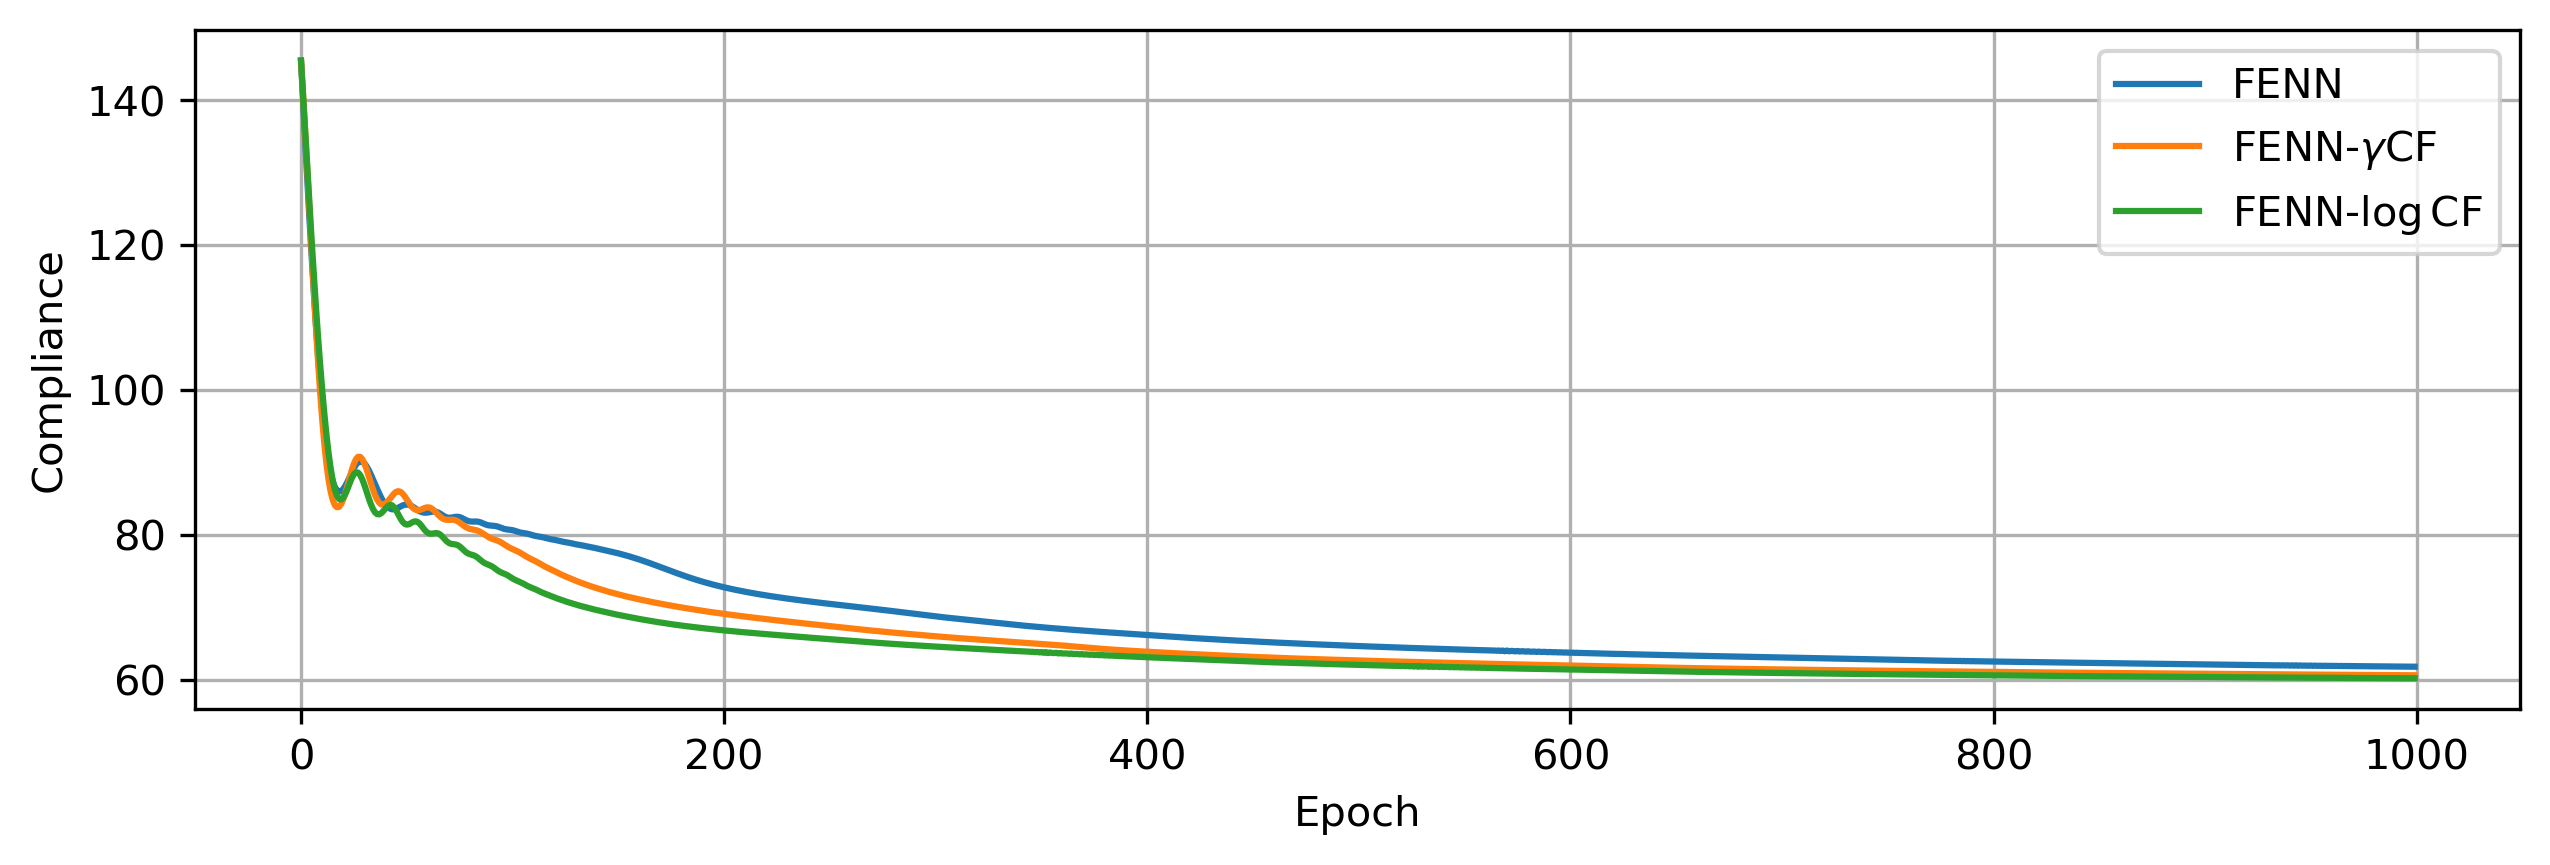

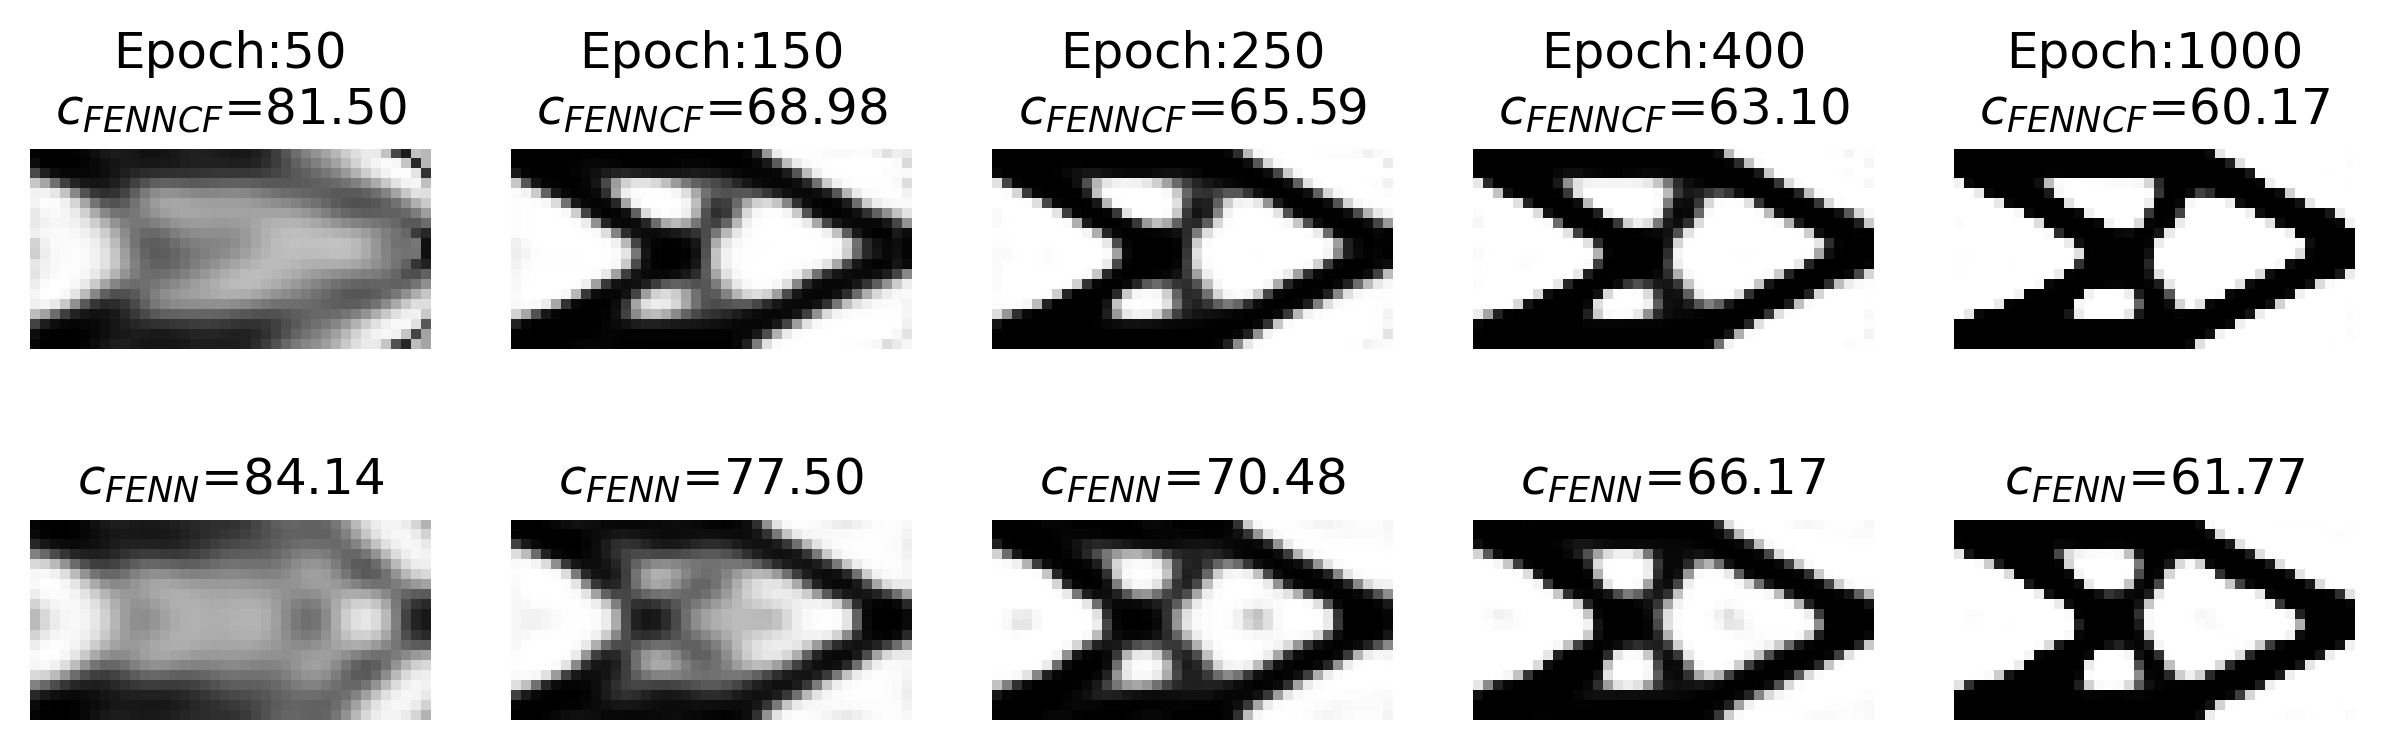

In [5]:
#convergence history plot
plt.figure(figsize=(10,3),dpi = 300)

#header = "_"+"{:.2f}".format(0.5)+"_"+"{:02d}".format(39)+"_"+"{:02d}".format(10)+"_"

plt.plot(opt_v.log_c ,label = "FENN")
plt.plot(opt_g.log_c,label = r"FENN-$\gamma$CF")
plt.plot(opt_l.log_c,label = r"FENN-$\log$CF")
plt.xlabel("Epoch")
plt.ylabel("Compliance")
plt.legend()
plt.grid()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(10,3),dpi = 300)
# plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10

i = 0
epochs = [50,150,250,400,1000]
for epoch in epochs:

    #hybrid
    xPhys = opt_l.log_xPhys[epoch-1].numpy()
    ax = axes.flat[i]
    im = ax.imshow(np.rot90(xPhys.reshape([40,20])),cmap = "binary")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.set_title("Epoch:"+str(epoch) + "\n"+ r'$c_{FENNCF}$'+"={:.2f}".format(opt_l.log_c[epoch-1]))

    #vanilla
    xPhys = opt_v.log_xPhys[epoch-1].numpy()
    ax = axes.flat[i+5]
    im = ax.imshow(np.rot90(xPhys.reshape([40,20])),cmap = "binary")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.set_title(r'$c_{FENN}$'+"={:.2f}".format(opt_v.log_c[epoch-1]))
    
    i+=1
plt.savefig("pic_conv_xPhys_1000.png")

In [ ]:
nelx = 40
nely = 20
for hybrid in [True]:
    for vf in np.linspace(0.2,0.5,4):
        for xid in range(nelx-5,nelx):
            for yid in range(0,10):


                problem = Cantilever_Beam_End_Points_Loads_2D(nelx,nely, xid, yid,vf)
                to_model = TO_Net(hybrid)
                opt = HybridTO(problem, to_model, hybrid)
                opt.fit_to(400)
                opt.save_result("HybridTO_results/")


In [ ]:
@widgets.interact(vf = (0.2,0.5,0.1),xid=(35,39),yid=(0,9))
def f(vf,xid,yid):
    header = "_"+"{:.2f}".format(vf)+"_"+"{:02d}".format(xid)+"_"+"{:02d}".format(yid)+"_"
    log_c_h = (np.load("parametric_results/h"+header+"log_c.npy"))
    log_c_v = (np.load("parametric_results/v"+header+"log_c.npy"))
    log_c_l = (np.load("HybridTO_results/l"+header+"log_c.npy"))
    xPhys_h = (np.load("HybridTO_results/h"+header+"log_xPhys.npy"))
    xPhys_v = (np.load("HybridTO_results/v"+header+"log_xPhys.npy"))
    plt.plot(log_c_v,label = "vanilla")
    plt.plot(log_c_l,label = "log hybrid")
    plt.plot(log_c_h,label = "hybrid")

    plt.legend()
    plt.show()

    plt.subplot(1,2,1)
    plt.imshow(np.rot90(xPhys_h.reshape([40,20])),cmap = "seismic")
    plt.title("hybrid")
    plt.subplot(1,2,2)
    plt.imshow(np.rot90(xPhys_v.reshape([40,20])),cmap = "seismic")
    plt.title("vanilla")    

In [ ]:
#varying SE field plot

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(11,1.5),dpi = 300)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10

i = 0
for vf in np.linspace(0.1,0.7,4):

    hybrid = True
    problem = Cantilever_Beam_End_Points_Loads_2D(40,20, 39, 0,vf)
    to_model = TO_Net(hybrid)
    opt = HybridTO(problem, to_model, hybrid = True , se_filter="log",debug=False)
    #opt.fit_to(400)

    c_init = opt.se_init_field()
    ax = axes.flat[i]
    im = ax.imshow(np.rot90(c_init.numpy().reshape([nelx,nely])))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("vf="+str(vf))
    #plt.colorbar()
    #plt.show()
    i += 1 
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig("pic_SE_filed_vf.png")
plt.show()

In [ ]:
#SE field normalization plot
vf = 0.5

problem = Cantilever_Beam_End_Points_Loads_2D(40,20, 39, 0,vf)
to_model = TO_Net(True)
opt = HybridTO(problem, to_model, hybrid = True, se_filter="log",debug=False)
#opt.fit_to(400)

c_init = opt.FE.strain_energy(tf.ones([800]),penal = 3)
plt.figure(figsize=(3,1.5),dpi = 300)
plt.imshow(np.rot90(c_init.reshape([nelx,nely])))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()

cbar.set_ticks(np.linspace(0, np.max(c_init), 5))
cbar.set_ticklabels(['%.2f' % t for t in np.linspace(0, np.max(c_init), 5)])
plt.savefig("pic_SE_raw.png")
plt.show()

med = np.percentile(c_init,99)
c_init[np.where(c_init>med)] = med

plt.figure(figsize=(3,1.5),dpi = 300)
plt.imshow(np.rot90(c_init.reshape([nelx,nely])))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()

cbar.set_ticks(np.linspace(0, np.max(c_init), 5))
cbar.set_ticklabels(['%.2f' % t for t in np.linspace(0, np.max(c_init), 5)])
plt.savefig("pic_SE_99.png")
plt.show()

c_init = (c_init - np.min(c_init))/(np.max(c_init) - np.min(c_init))
c_init = c_init**(1.0-vf)*0.4

plt.figure(figsize=(3,1.5),dpi = 300)
plt.imshow(np.rot90(c_init.reshape([nelx,nely])))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()

cbar.set_ticks(np.linspace(0, np.max(c_init), 5))
cbar.set_ticklabels(['%.2f' % t for t in np.linspace(0, np.max(c_init), 5)])
plt.savefig("pic_SE_norm.png")
plt.show()

c_init = opt.se_init_field().numpy()

plt.figure(figsize=(3,1.5),dpi = 300)
plt.imshow(np.rot90(c_init.reshape([nelx,nely])))
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()

cbar.set_ticks(np.linspace(0, np.max(c_init), 5))
cbar.set_ticklabels(['%.2f' % t for t in np.linspace(0, np.max(c_init), 5)])
plt.savefig("pic_SE_log.png")
plt.show()

In [ ]:
log_c_h = []
log_c_v = []
log_c_l = []
hybrid_itr_h = []
hybrid_itr_l = []
nelx = 40
nely = 20



for vf in np.linspace(0.2,0.5,4):
    for xid in range(nelx-5,nelx):
        for yid in range(0,10):
            header = "_"+"{:.2f}".format(vf)+"_"+"{:02d}".format(xid)+"_"+"{:02d}".format(yid)+"_log_c.npy"

            log_cvnp = np.load("parametric_results/v"+header)
            log_chnp = np.load("parametric_results/h"+header)
            log_clnp = np.load("parametric_results/l"+header)

            log_c_h.append(log_chnp[-1])
            log_c_v.append(log_cvnp[-1])
            log_c_l.append(log_clnp[-1])
            # log_cvnp = log_cvnp[50:-1]
            # log_chnp = log_chnp[50:-1]
            bool_array = log_cvnp[-1]>log_chnp
            trans = [i for i in range(0,len(bool_array)) if list(bool_array[i:i+2])==[False,True]]
            if trans:
                hybrid_itr_h.append(max(trans))
            else:
                if np.mean(bool_array) == 1:
                    hybrid_itr_h.append(0)
                else:
                    hybrid_itr_h.append(400)

            bool_array = log_cvnp[-1]>log_clnp
            trans = [i for i in range(0,len(bool_array)) if list(bool_array[i:i+2])==[False,True]]
            if trans:
                hybrid_itr_l.append(max(trans))
            else:
                if np.mean(bool_array) == 1:
                    hybrid_itr_l.append(0)
                else:
                    hybrid_itr_l.append(400)

log_c_h = np.array(log_c_h)
log_c_v = np.array(log_c_v)
log_c_l = np.array(log_c_l)
hybrid_itr_h = np.array(hybrid_itr_h)
hybrid_itr_l = np.array(hybrid_itr_l)
sorted_indices = np.argsort(log_c_v)



In [ ]:
%matplotlib inline
#plt.figure(figsize=(5,5),dpi = 300)
fig, ax = plt.subplots(figsize=(5,5),dpi = 300)
plt.plot(log_c_v[sorted_indices],label="FENN")
plt.plot(log_c_h[sorted_indices],label=r"FENN-$\gamma$CF")
plt.plot(log_c_l[sorted_indices],label=r"FENN-$log$CF")
plt.legend()
#plt.title('Compliance comparison')
plt.xlabel('Solution Number')
plt.ylabel('Compliance')
plt.yscale("log")
ax.set_yticks(np.linspace(100,800,8))
ax.set_yticklabels(np.linspace(100,800,8))
plt.grid()
plt.show()

plt.savefig("pic_c_compare.png")

In [ ]:
%matplotlib inline
#plt.figure(figsize=(5,5),dpi = 300)
fig, ax = plt.subplots(figsize=(5,5),dpi = 300)

percentage_h = (400 - hybrid_itr_h[sorted_indices])/400
plt.plot(percentage_h,label=r"FENN-$\gamma$CF")
percentage_l = (400 - hybrid_itr_l[sorted_indices])/400
plt.plot(percentage_l,label=r"FENN-$log$CF")
#plt.title('Compliance comparison')
plt.xlabel('Solution Number')
plt.ylabel('Percentage improvement')
# plt.yscale("log")
# ax.set_yticks(np.linspace(100,800,8))
# ax.set_yticklabels(np.linspace(100,800,8))

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.legend()
plt.grid()
plt.show()

print("average hybrid:",np.mean(percentage_h))
print("average log:",np.mean(percentage_l))
plt.savefig("pic_c_percent.png")

In [ ]:
#Parametric compliance and topology compare plot,  pic_c_compare_xPhys.png
nelx = 40
nely = 20

ids = [[39,9],[39,0],[37,5],[35,9],[35,0]]

i = 0


fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(10,3),dpi = 300)
# plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10

for xid,yid in ids :
    vf = 0.3
    header = "_"+"{:.2f}".format(vf)+"_"+"{:02d}".format(xid)+"_"+"{:02d}".format(yid)

    xPhys_v = np.load("parametric_results/v"+header+"_log_xPhys.npy").reshape([nelx,nely])
    xPhys_h = np.load("parametric_results/h"+header+"_log_xPhys.npy").reshape([nelx,nely])

    c_v = np.load("parametric_results/v"+header+"_log_c.npy")[-1]
    c_h = np.load("parametric_results/h"+header+"_log_c.npy")[-1]

    #hybrid

    ax = axes.flat[i]
    im = ax.imshow(np.rot90(xPhys_h),cmap = "binary")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title( r'$c_{FENNCF}$'+"={:.2f}".format(c_h))
    ax.axis('off')

    #vanilla
    ax = axes.flat[i+5]
    im = ax.imshow(np.rot90(xPhys_v),cmap = "binary")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(r'$c_{FENN}$'+"={:.2f}".format(c_v))
    ax.axis('off')
    i += 1

fig.savefig("pic_c_compare_xPhys.png")

In [ ]:
#code to run the parametric study
nelx = 40
nely = 20
for vf in np.linspace(0.2,0.5,4):
    for xid in range(nelx-5,nelx):
        for yid in range(0,nely):

            hybrid = True
            problem = Cantilever_Beam_End_Points_Loads_2D(nelx,nely, xid, yid,vf)
            to_model = TO_Net(hybrid)
            opt = HybridTO(problem, to_model, hybrid,se_filter="log",debug=False)
            opt.fit_to(400)
            opt.save_result("parametric_results/")

for vf in np.linspace(0.2,0.5,4):
    for xid in range(nelx-5,nelx):
        for yid in range(0,nely):

            hybrid = True
            problem = Cantilever_Beam_End_Points_Loads_2D(nelx,nely, xid, yid,vf)
            to_model = TO_Net(hybrid)
            opt = HybridTO(problem, to_model, hybrid,se_filter="gamma",debug=False)
            opt.fit_to(400)
            opt.save_result("parametric_results/")

for vf in np.linspace(0.4,0.5,2):
    for xid in range(nelx-5,nelx):
        for yid in range(0,nely):

            hybrid = False
            problem = Cantilever_Beam_End_Points_Loads_2D(nelx,nely, xid, yid,vf)
            to_model = TO_Net(hybrid)
            opt = HybridTO(problem, to_model, hybrid,se_filter="gamma",debug=False)
            opt.fit_to(400)
            opt.save_result("parametric_results/")